# Exercise 5: Replica exchange umbrella sampling

## Instructor/Author
Wei-Tse Hsu
- University of Colorado Boulder
- www.weitsehsu.com
- wehs7661@colorado.edu
- [@WeiTseHsu](https://twitter.com/WeiTseHsu)

If you're interested, check my personal website for more future posts/tutorials about advanced sampling methods!

In this exercise, our goal is to run replica exchange umbrella sampling (REUS) for the NaCl system to recover a free energy surface consistent with what we got from Exercise 2 (umbrella sampling) and Exercise 3 (multiple walkers metadynamics). Again, we will perform the simulation in the NVT ensemble. 

In [1]:
%%bash
# Here we remove the output of the exercise if there is any.
dirs=(rep_* small_k large_k colvar)
for dir in "${dirs[@]}"; do
    if ls -d "$dir" >/dev/null 2>&1; then
        rm -rf "$dir"
    fi
done

## 1. Preparation of the input files

Here we will stick with 8 intermediate states (hence 8 replicas), with each of them having a different center for the umbrella potential. This requires us to set up 8 folders. 

In [2]:
%%bash
for i in {0..7}
do
    mkdir rep_${i} && cd rep_${i}
    cp ../../Exercise_2/sim_${i}/NaCl_${i}.gro NaCl.gro   # configurations from the pulling ismulation in Exercise 2
    cp ../../Exercise_2/pull/NaCl_US.top NaCl.top
    cp ../../Inputs/NaCl/MD-NVT.mdp .
    cd ../
done

While it is possible to use only GROMACS to perform replica exchange umbrella sampling, it is easier to use the combination of GROMACS and PLUMED because PLUMED has much better flexibility in formulating the restraint. This means that we will need a different PLUMED input files for different replicas/folders.

In [3]:
%%bash
module load gromacs/2020.2-cpu openmpi/4.0.5-gcc10.2.0
mkdir colvar
d=(0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6)  # centers
for i in {0..7}
do
    center=${d[$i]}
    echo "d: DISTANCE ATOMS=322,323
r: RESTRAINT ARG=d KAPPA=8000 AT=${center}
PRINT ARG=d,r.bias FILE=../colvar/colvar_multi.dat STRIDE=100
    " > plumed.dat
    mv plumed.dat rep_${i}/.
    cd rep_${i} && mpirun -np 1 gmx_mpi grompp -f MD-NVT.mdp -c NaCl.gro -p NaCl.top -o NaCl_REUS.tpr && cd ../
done

                 :-) GROMACS - gmx grompp, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
 

turning H bonds into constraints...


Excluding 1 bonded neighbours molecule type 'NA'
Excluding 1 bonded neighbours molecule type 'CL'


turning H bonds into constraints...
turning H bonds into constraints...


Setting gen_seed to 1263011159
Velocities were taken from a Maxwell distribution at 300 K


Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...


Number of degrees of freedom in T-Coupling group System is 645.00


Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm
Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106


Estimate for the relative computational load of the PME mesh part: 0.51

NOTE 1 [file MD-NVT.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off and the PME grid spacing.




This run will generate roughly 9 Mb of data



There was 1 note

GROMACS reminds you: "Does All This Money Really Have To Go To Charity ?" (Rick)

                 :-) GROMACS - gmx grompp, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...


Excluding 1 bonded neighbours molecule type 'NA'
Excluding 1 bonded neighbours molecule type 'CL'
Setting gen_seed to 832308448
Velocities were taken from a Maxwell distribution at 300 K


Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm
Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106
This run will generate roughly 9 Mb of data


Number of degrees of freedom in T-Coupling group System is 645.00
Estimate for the relative computational load of the PME mesh part: 0.51

NOTE 1 [file MD-NVT.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off and the PME grid spacing.



There was 1 note

GROMACS reminds you: "...sometimes a scream is better than a thesis." (Ralph Waldo Emerson)

                 :-) GROMACS - gmx grompp, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson 

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...


Excluding 1 bonded neighbours molecule type 'NA'
Excluding 1 bonded neighbours molecule type 'CL'
Setting gen_seed to -1194417719
Velocities were taken from a Maxwell distribution at 300 K


Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm
Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106
This run will generate roughly 9 Mb of data


Number of degrees of freedom in T-Coupling group System is 645.00
Estimate for the relative computational load of the PME mesh part: 0.51

NOTE 1 [file MD-NVT.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off and the PME grid spacing.



There was 1 note

GROMACS reminds you: "On average, it takes twenty years for the world's largest super computer to shrink down to the size of your laptop." (Pete Beckman)

                 :-) GROMACS - gmx grompp, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Jun

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...


Excluding 1 bonded neighbours molecule type 'NA'
Excluding 1 bonded neighbours molecule type 'CL'
Setting gen_seed to -2038272028
Velocities were taken from a Maxwell distribution at 300 K


Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm
Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106
This run will generate roughly 9 Mb of data


Number of degrees of freedom in T-Coupling group System is 645.00
Estimate for the relative computational load of the PME mesh part: 0.51

NOTE 1 [file MD-NVT.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off and the PME grid spacing.



There was 1 note

GROMACS reminds you: "Move Over Hogey Bear" (Urban Dance Squad)

                 :-) GROMACS - gmx grompp, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carst

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...


Excluding 1 bonded neighbours molecule type 'NA'
Excluding 1 bonded neighbours molecule type 'CL'
Setting gen_seed to 1002187967
Velocities were taken from a Maxwell distribution at 300 K


Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm
Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106
This run will generate roughly 9 Mb of data


Number of degrees of freedom in T-Coupling group System is 645.00
Estimate for the relative computational load of the PME mesh part: 0.51

NOTE 1 [file MD-NVT.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off and the PME grid spacing.



There was 1 note

GROMACS reminds you: "There's no way you can rely on an experiment" (Gerrit Groenhof)

                 :-) GROMACS - gmx grompp, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson       

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...


Excluding 1 bonded neighbours molecule type 'NA'
Excluding 1 bonded neighbours molecule type 'CL'
Setting gen_seed to -1629767087
Velocities were taken from a Maxwell distribution at 300 K


Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm
Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106
This run will generate roughly 9 Mb of data


Number of degrees of freedom in T-Coupling group System is 645.00
Estimate for the relative computational load of the PME mesh part: 0.51

NOTE 1 [file MD-NVT.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off and the PME grid spacing.



There was 1 note

GROMACS reminds you: "The loveliest theories are being overthrown by these damned experiments; it is no fun being a chemist any more." (Justus von Liebig, letter to J.J. Berzelius 1834)

                 :-) GROMACS - gmx grompp, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
 

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...


Excluding 1 bonded neighbours molecule type 'NA'
Excluding 1 bonded neighbours molecule type 'CL'
Setting gen_seed to -1142341327
Velocities were taken from a Maxwell distribution at 300 K


Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm
Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106
This run will generate roughly 9 Mb of data


Number of degrees of freedom in T-Coupling group System is 645.00
Estimate for the relative computational load of the PME mesh part: 0.51

NOTE 1 [file MD-NVT.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off and the PME grid spacing.



There was 1 note

GROMACS reminds you: "This Doesn't Suck, It's a Black Hole !" (K.A. Feenstra)

                 :-) GROMACS - gmx grompp, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kr

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...


Excluding 1 bonded neighbours molecule type 'NA'
Excluding 1 bonded neighbours molecule type 'CL'
Setting gen_seed to 1203178728
Velocities were taken from a Maxwell distribution at 300 K


Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm
Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106
This run will generate roughly 9 Mb of data


Number of degrees of freedom in T-Coupling group System is 645.00
Estimate for the relative computational load of the PME mesh part: 0.51

NOTE 1 [file MD-NVT.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off and the PME grid spacing.



There was 1 note

GROMACS reminds you: "These Gromacs Guys Really Rock" (P.J. Meulenhoff)



## 2. Running REUS simulations

In [4]:
%%time
%%bash
module load gromacs/2020.2-cpu openmpi/4.0.5-gcc10.2.0

mpirun -np 8 gmx_mpi mdrun -s NaCl_REUS.tpr -plumed plumed.dat -multidir rep_{0..7} -replex 100 -ntomp 1

                  :-) GROMACS - gmx mdrun, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
 

CPU times: user 88.7 ms, sys: 19.6 ms, total: 108 ms
Wall time: 45.8 s


## 3. Data analysis

In [5]:
%%bash
ls colvar/*dat

colvar/colvar_multi.0.dat
colvar/colvar_multi.1.dat
colvar/colvar_multi.2.dat
colvar/colvar_multi.3.dat
colvar/colvar_multi.4.dat
colvar/colvar_multi.5.dat
colvar/colvar_multi.6.dat
colvar/colvar_multi.7.dat


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

# Just some settings for plotting
rc('font', **{
    'family': 'sans-serif',
    'sans-serif': ['DejaVu Sans'],
    'size': 10,
})
# Set the font used for MathJax - more on thiprint(images)
rc('mathtext', **{'default': 'regular'})
plt.rc('font', family='serif')

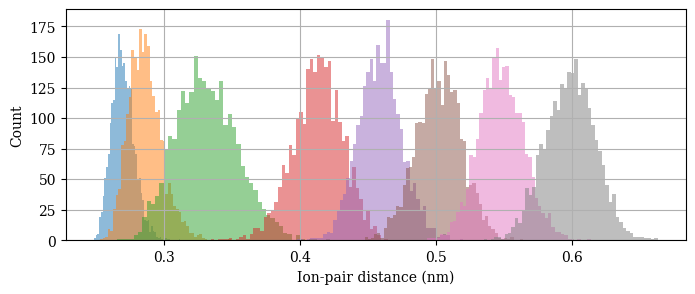

In [7]:
pullx_data = [np.transpose(np.loadtxt(f'colvar/colvar_multi.{i}.dat', comments=['@', '#'])) for i in range(8)]
dist_list = [data[1] for data in pullx_data]

plt.figure(figsize=(8, 3))
for i in range(8):
    plt.hist(dist_list[i], bins=50, alpha=0.5)
plt.xlabel('Ion-pair distance (nm)')
plt.ylabel('Count')
plt.grid()

The protocol for calculating the free energy profile we use here is exactly the same as the one we used for umbrella sampling in Exercise 2. The only meed to modify the parameters, including the number of samples, and the centers of the umbrella potentials.

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.


Statistical inefficiency of simulation 0: 1.419
Statistical inefficiency of simulation 1: 1.353
Statistical inefficiency of simulation 2: 2.491
Statistical inefficiency of simulation 3: 2.130
Statistical inefficiency of simulation 4: 1.530
Statistical inefficiency of simulation 5: 2.078
Statistical inefficiency of simulation 6: 1.448
Statistical inefficiency of simulation 7: 1.564


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)



Time elapsed: 2 seconds.


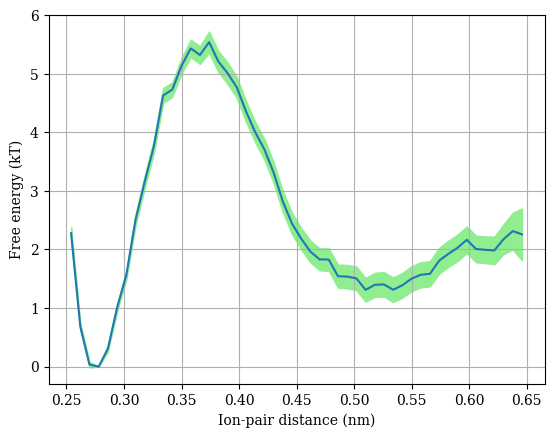

In [8]:
import time
import pymbar
from pymbar import timeseries
import random
import scipy.stats

t0 = time.time()

# Step 1: Setting up
K = 8                                       # number of umbrellas
N_max = 2501                                # number of data points in each timeseries of ion-pair distance
kT = 1.381e-23 * 6.022e23 / 1000 * 300      # 1 kT converted to kJ/mol at 300 K
beta_k = np.ones(K) / kT                    # inverse temperature of simulations (in 1/(kJ/mol)) 
d_min, d_max = 0.25, 0.65                   # minimum and maximum of the CV for plotting the FES
nbins = 50                                  # number of bins for FES
K_k = np.ones(K) * 8000                     # spring constant (in kJ/mol/nm**2) for different simulations
N_k, g_k = np.zeros(K, int), np.zeros(K)    # number of samples and statistical inefficiency of different simulations
d_kn = np.zeros([K, N_max])                 # d_kn[k,n] is the ion-pair distance (in nm) for snapshot n from umbrella simulation k
u_kn = np.zeros([K, N_max])                 # u_kn[k,n] is the reduced potential energy without umbrella restraints of snapshot n of umbrella simulation k
uncorrelated_samples = []                   # Uncorrelated samples of different simulations

# Step 2: Read in and subsample the timeseries
for k in range(K):
    d_kn[k] = np.transpose(np.loadtxt(f'colvar/colvar_multi.{k}.dat', comments=['@', '#']))[1]
    N_k[k] = len(d_kn[k])
    d_temp = d_kn[k, 0:N_k[k]]
    g_k[k] = timeseries.statistical_inefficiency(d_temp)     
    print(f"Statistical inefficiency of simulation {k}: {g_k[k]:.3f}")
    indices = timeseries.subsample_correlated_data(d_temp, g=g_k[k]) # indices of the uncorrelated samples
    
    # Update u_kn and d_kn with uncorrelated samples
    N_k[k] = len(indices)    # At this point, N_k contains the number of uncorrelated samples for each state k                
    u_kn[k, 0:N_k[k]] = u_kn[k, indices]
    d_kn[k, 0:N_k[k]] = d_kn[k, indices]
    uncorrelated_samples.append(d_kn[k, indices])

d0_k = np.array([0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6])
N_max = np.max(N_k) # shorten the array size
u_kln = np.zeros([K, K, N_max]) # u_kln[k,l,n] is the reduced potential energy of snapshot n from umbrella simulation k evaluated at umbrella l
u_kn -= u_kn.min()  # shift the minimum of the FES to 0

# Step 3: Bin the data
bin_center_i = np.zeros([nbins])
bin_edges = np.linspace(d_min, d_max, nbins + 1)
for i in range(nbins):
    bin_center_i[i] = 0.5 * (bin_edges[i] + bin_edges[i + 1])
   
# Step 4: Evaluate reduced energies in all umbrellas
for k in range(K):
    for n in range(N_k[k]):
        # Compute minimum-image ion-pair distance deviation from umbrella center l
        dd = d_kn[k,n] - d0_k  # delta d

        # Compute energy of snapshot n from simulation k in umbrella potential l
        u_kln[k,:,n] = u_kn[k,n] + beta_k[k] * (K_k / 2) * dd ** 2

# Step 5: Compute, output, and plot the FES
fes = pymbar.FES(u_kln, N_k, verbose=False)
histo_params = {'bin_edges': bin_edges}
d_n = pymbar.utils.kn_to_n(d_kn, N_k=N_k)
fes.generate_fes(u_kn, d_n, fes_type='histogram', histogram_parameters=histo_params)
results = fes.get_fes(bin_center_i, reference_point="from-lowest", uncertainty_method="analytical")
f_i = results["f_i"]
df_i = results["df_i"]

with open('fes.dat', 'w') as f:
    f.write("# free energy profile (in units of kT), from histogramming\n")
    f.write(f"# {'bin':>8s} {'f':>8s} {'df':>8s} \n")
    for i in range(nbins):
       f.write(f"{bin_center_i[i]:>8.3f} {f_i[i]:>8.3f} {df_i[i]:>8.3f} \n")

plt.figure()
plt.plot(bin_center_i, f_i)
plt.fill_between(bin_center_i, f_i - df_i, f_i + df_i, color='lightgreen')
plt.xlabel('Ion-pair distance (nm)')
plt.ylabel('Free energy (kT)')
plt.grid()

t1 = time.time()
print(f'\nTime elapsed: {t1 - t0:.0f} seconds.')

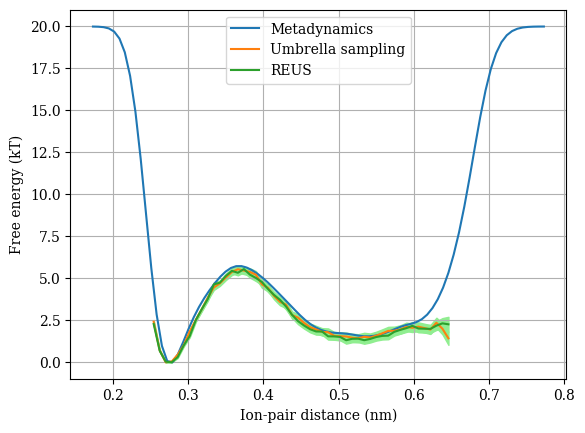

In [9]:
fes_MetaD = np.transpose(np.loadtxt('../Exercise_3/mpi_based/fes.dat', comments=['@', '#']))
fes_US = np.transpose(np.loadtxt('../Exercise_2/fes.dat', comments=['@', '#']))
fes_REUS = np.transpose(np.loadtxt('fes.dat', comments=['@', '#']))

fes_US[1] -= min(fes_US[1])
fes_REUS[1] -= min(fes_REUS[1])

kT = 300 * 1.380649E-23 * 6.02214076E23 / 1000   # 1 kT in kJ/mol
plt.plot(fes_MetaD[0], fes_MetaD[1] / kT, label='Metadynamics')
plt.plot(fes_US[0], fes_US[1] - min(fes_US[1]), label='Umbrella sampling')
plt.plot(fes_REUS[0], fes_REUS[1] - min(fes_REUS[1]), label='REUS')

plt.fill_between(fes_US[0], fes_US[1] - fes_US[2], fes_US[1] + fes_US[2], color='lightgreen')
plt.fill_between(fes_REUS[0], fes_REUS[1] - fes_REUS[2], fes_REUS[1] + fes_REUS[2], color='lightgreen')
plt.xlabel('Ion-pair distance (nm)')
plt.ylabel('Free energy (kT)')
plt.legend()
plt.grid()

As shown above, the three free energy surfaces are pretty consistent with each other!

## 4. Supplmentary notes: The importance of the force constant

Due to the time limit, this supplementary section was not presented during the lecture, but here let's discuss more about choosing a force constant in methods like umbrella sampling or replica exchange umbrella sampling. 

As mentioned in Exercise 2, the force constant used in umbrella sampling (or more generally, a simulation where we want to fix the configurations in different regions of CV values, including replica exchange umbrella sampling) should be large enough to prevent the configurations from drifting to the nearest metastable states, but also not too large so that the CV distributions won't be too narrow to have sufficient overlap with the neighboring distributions. Here, let's try different force constants and see how they influence the overlap between neighboring distributions in replica exchange umbrella sampling. 

### 4-1. A small force constant

Here let's try a small force constant of 500 $\mathrm{kJ/mol/nm^2}$.

In [10]:
%%bash
mkdir small_k && cd small_k
for i in {0..7}
do
    mkdir rep_${i} && cd rep_${i}
    cp ../../../Exercise_2/sim_${i}/NaCl_${i}.gro NaCl.gro   # configurations from the pulling ismulation in Exercise 2
    cp ../../../Exercise_2/pull/NaCl_US.top NaCl.top
    cp ../../../Inputs/NaCl/MD-NVT.mdp .
    cd ../
done

In [11]:
%%bash
module load gromacs/2020.2-cpu openmpi/4.0.5-gcc10.2.0
cd small_k && mkdir colvar
d=(0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6)  # centers
for i in {0..7}
do
    center=${d[$i]}
    echo "d: DISTANCE ATOMS=322,323
r: RESTRAINT ARG=d KAPPA=500 AT=${center}
PRINT ARG=d,r.bias FILE=../colvar/colvar_multi.dat STRIDE=100
    " > plumed.dat
    mv plumed.dat rep_${i}/.
    cd rep_${i} && mpirun -np 1 gmx_mpi grompp -f MD-NVT.mdp -c NaCl.gro -p NaCl.top -o NaCl_REUS.tpr && cd ../
done

                 :-) GROMACS - gmx grompp, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
 

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...


Excluding 1 bonded neighbours molecule type 'NA'
Excluding 1 bonded neighbours molecule type 'CL'
Setting gen_seed to 16947029
Velocities were taken from a Maxwell distribution at 300 K


Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm
Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106
This run will generate roughly 9 Mb of data


Number of degrees of freedom in T-Coupling group System is 645.00
Estimate for the relative computational load of the PME mesh part: 0.51

NOTE 1 [file MD-NVT.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off and the PME grid spacing.



There was 1 note

GROMACS reminds you: "Good Music Saves your Soul" (Lemmy)

                 :-) GROMACS - gmx grompp, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kut

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...


Excluding 1 bonded neighbours molecule type 'NA'
Excluding 1 bonded neighbours molecule type 'CL'
Setting gen_seed to 1366896617
Velocities were taken from a Maxwell distribution at 300 K


Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm
Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106
This run will generate roughly 9 Mb of data


Number of degrees of freedom in T-Coupling group System is 645.00
Estimate for the relative computational load of the PME mesh part: 0.51

NOTE 1 [file MD-NVT.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off and the PME grid spacing.



There was 1 note

GROMACS reminds you: "Everything's formed from particles" (Van der Graaf Generator)

                 :-) GROMACS - gmx grompp, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        J

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...


Excluding 1 bonded neighbours molecule type 'NA'
Excluding 1 bonded neighbours molecule type 'CL'
Setting gen_seed to 2082730332
Velocities were taken from a Maxwell distribution at 300 K


Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm
Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106
This run will generate roughly 9 Mb of data


Number of degrees of freedom in T-Coupling group System is 645.00
Estimate for the relative computational load of the PME mesh part: 0.51

NOTE 1 [file MD-NVT.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off and the PME grid spacing.



There was 1 note

GROMACS reminds you: "In my opinion, we don't devote nearly enough scientific research to finding a cure for jerks." (Bill Watterson)

                 :-) GROMACS - gmx grompp, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...


Excluding 1 bonded neighbours molecule type 'NA'
Excluding 1 bonded neighbours molecule type 'CL'
Setting gen_seed to 1192869059
Velocities were taken from a Maxwell distribution at 300 K


Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm
Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106
This run will generate roughly 9 Mb of data


Number of degrees of freedom in T-Coupling group System is 645.00
Estimate for the relative computational load of the PME mesh part: 0.51

NOTE 1 [file MD-NVT.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off and the PME grid spacing.



There was 1 note

GROMACS reminds you: "I Have a Bad Case Of Purple Diarrhea" (Urban Dance Squad)

                 :-) GROMACS - gmx grompp, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri 

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...


Excluding 1 bonded neighbours molecule type 'NA'
Excluding 1 bonded neighbours molecule type 'CL'
Setting gen_seed to -1623978024
Velocities were taken from a Maxwell distribution at 300 K


Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm
Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106
This run will generate roughly 9 Mb of data


Number of degrees of freedom in T-Coupling group System is 645.00
Estimate for the relative computational load of the PME mesh part: 0.51

NOTE 1 [file MD-NVT.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off and the PME grid spacing.



There was 1 note

GROMACS reminds you: "To survive science you have to become science." (Gerrit Groenhof)

                 :-) GROMACS - gmx grompp, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson     

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...


Excluding 1 bonded neighbours molecule type 'NA'
Excluding 1 bonded neighbours molecule type 'CL'
Setting gen_seed to 1320418608
Velocities were taken from a Maxwell distribution at 300 K


Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm
Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106
This run will generate roughly 9 Mb of data


Number of degrees of freedom in T-Coupling group System is 645.00
Estimate for the relative computational load of the PME mesh part: 0.51

NOTE 1 [file MD-NVT.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off and the PME grid spacing.



There was 1 note

GROMACS reminds you: "Gabba Gabba Hey!" (The Ramones)

                 :-) GROMACS - gmx grompp, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...


Excluding 1 bonded neighbours molecule type 'NA'
Excluding 1 bonded neighbours molecule type 'CL'
Setting gen_seed to -117285155
Velocities were taken from a Maxwell distribution at 300 K


Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm
Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106
This run will generate roughly 9 Mb of data


Number of degrees of freedom in T-Coupling group System is 645.00
Estimate for the relative computational load of the PME mesh part: 0.51

NOTE 1 [file MD-NVT.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off and the PME grid spacing.



There was 1 note

GROMACS reminds you: "Oh, There Goes Gravity" (Eminem)

                 :-) GROMACS - gmx grompp, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzne

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...


Excluding 1 bonded neighbours molecule type 'NA'
Excluding 1 bonded neighbours molecule type 'CL'
Setting gen_seed to 1576532572
Velocities were taken from a Maxwell distribution at 300 K


Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm
Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106
This run will generate roughly 9 Mb of data


Number of degrees of freedom in T-Coupling group System is 645.00
Estimate for the relative computational load of the PME mesh part: 0.51

NOTE 1 [file MD-NVT.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off and the PME grid spacing.



There was 1 note

GROMACS reminds you: "O My God, They Killed Kenny !" (South Park)



In [12]:
%%bash
module load gromacs/2020.2-cpu openmpi/4.0.5-gcc10.2.0
cd small_k && mpirun -np 8 gmx_mpi mdrun -s NaCl_REUS.tpr -plumed plumed.dat -multidir rep_{0..7} -replex 100 -ntomp 1

                  :-) GROMACS - gmx mdrun, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
 

Replica 0: mean = 0.279 nm (drift = 0.029 nm), std = 0.018 nm
Replica 1: mean = 0.284 nm (drift = 0.016 nm), std = 0.031 nm
Replica 2: mean = 0.321 nm (drift = 0.029 nm), std = 0.079 nm
Replica 3: mean = 0.411 nm (drift = 0.011 nm), std = 0.102 nm
Replica 4: mean = 0.483 nm (drift = 0.033 nm), std = 0.075 nm
Replica 5: mean = 0.523 nm (drift = 0.023 nm), std = 0.056 nm
Replica 6: mean = 0.556 nm (drift = 0.006 nm), std = 0.062 nm
Replica 7: mean = 0.599 nm (drift = 0.001 nm), std = 0.070 nm


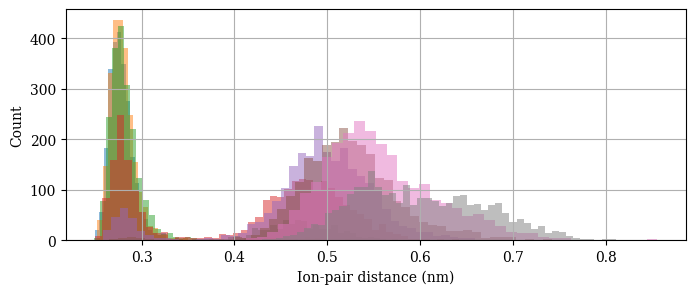

In [13]:
pullx_data = [np.transpose(np.loadtxt(f'small_k/colvar/colvar_multi.{i}.dat', comments=['@', '#'])) for i in range(8)]
dist_list = [data[1] for data in pullx_data]

plt.figure(figsize=(8, 3))
for i in range(8):
    print(f'Replica {i}: mean = {np.mean(dist_list[i]):.3f} nm (drift = {np.abs(np.mean(dist_list[i]) - d0_k[i]):.3f} nm), std = {np.std(dist_list[i]):.3f} nm')
    plt.hist(dist_list[i], bins=50, alpha=0.5)
plt.xlabel('Ion-pair distance (nm)')
plt.ylabel('Count')
plt.grid()

As shown above, all distributions moved towards to the nearest metastable states since the force constant was too small to fix them.

## 4-2. A large force constant

This time, let's try a large force constant of 50000 $\mathrm{kJ/mol/nm^2}$.

In [14]:
%%bash
mkdir large_k && cd large_k
for i in {0..7}
do
    mkdir rep_${i} && cd rep_${i}
    cp ../../../Exercise_2/sim_${i}/NaCl_${i}.gro NaCl.gro   # configurations from the pulling ismulation in Exercise 2
    cp ../../../Exercise_2/pull/NaCl_US.top NaCl.top
    cp ../../../Inputs/NaCl/MD-NVT.mdp .
    cd ../
done

In [15]:
%%bash
module load gromacs/2020.2-cpu openmpi/4.0.5-gcc10.2.0
cd large_k && mkdir colvar
d=(0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6)  # centers
for i in {0..7}
do
    center=${d[$i]}
    echo "d: DISTANCE ATOMS=322,323
r: RESTRAINT ARG=d KAPPA=50000 AT=${center}
PRINT ARG=d,r.bias FILE=../colvar/colvar_multi.dat STRIDE=100
    " > plumed.dat
    mv plumed.dat rep_${i}/.
    cd rep_${i} && mpirun -np 1 gmx_mpi grompp -f MD-NVT.mdp -c NaCl.gro -p NaCl.top -o NaCl_REUS.tpr && cd ../
done

                 :-) GROMACS - gmx grompp, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
 

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...


Excluding 1 bonded neighbours molecule type 'NA'
Excluding 1 bonded neighbours molecule type 'CL'
Setting gen_seed to -2092989898
Velocities were taken from a Maxwell distribution at 300 K


Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm
Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106
This run will generate roughly 9 Mb of data


Number of degrees of freedom in T-Coupling group System is 645.00
Estimate for the relative computational load of the PME mesh part: 0.51

NOTE 1 [file MD-NVT.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off and the PME grid spacing.



There was 1 note

GROMACS reminds you: "There was no preconception on what to do" (Daft Punk)

                 :-) GROMACS - gmx grompp, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Krau

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...


Excluding 1 bonded neighbours molecule type 'NA'
Excluding 1 bonded neighbours molecule type 'CL'
Setting gen_seed to -2020599951
Velocities were taken from a Maxwell distribution at 300 K


Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm
Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106
This run will generate roughly 9 Mb of data


Number of degrees of freedom in T-Coupling group System is 645.00
Estimate for the relative computational load of the PME mesh part: 0.51

NOTE 1 [file MD-NVT.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off and the PME grid spacing.



There was 1 note

GROMACS reminds you: "I Had So Many Problem, and Then I Got Me a Walkman" (F. Black)

                 :-) GROMACS - gmx grompp, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...


Excluding 1 bonded neighbours molecule type 'NA'
Excluding 1 bonded neighbours molecule type 'CL'
Setting gen_seed to -654448695
Velocities were taken from a Maxwell distribution at 300 K


Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm
Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106
This run will generate roughly 9 Mb of data


Number of degrees of freedom in T-Coupling group System is 645.00
Estimate for the relative computational load of the PME mesh part: 0.51

NOTE 1 [file MD-NVT.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off and the PME grid spacing.



There was 1 note

GROMACS reminds you: "It's Against the Rules" (Pulp Fiction)

                 :-) GROMACS - gmx grompp, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten 

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...


Excluding 1 bonded neighbours molecule type 'NA'
Excluding 1 bonded neighbours molecule type 'CL'
Setting gen_seed to 1375416591
Velocities were taken from a Maxwell distribution at 300 K


Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm
Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106
This run will generate roughly 9 Mb of data


Number of degrees of freedom in T-Coupling group System is 645.00
Estimate for the relative computational load of the PME mesh part: 0.51

NOTE 1 [file MD-NVT.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off and the PME grid spacing.



There was 1 note

GROMACS reminds you: "If You See Me Getting High, Knock Me Down" (Red Hot Chili Peppers)

                 :-) GROMACS - gmx grompp, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson    

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...


Excluding 1 bonded neighbours molecule type 'NA'
Excluding 1 bonded neighbours molecule type 'CL'
Setting gen_seed to 1604188253
Velocities were taken from a Maxwell distribution at 300 K


Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm
Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106
This run will generate roughly 9 Mb of data


Number of degrees of freedom in T-Coupling group System is 645.00
Estimate for the relative computational load of the PME mesh part: 0.51

NOTE 1 [file MD-NVT.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off and the PME grid spacing.



There was 1 note

GROMACS reminds you: "I was taught that the way of progress was neither swift nor easy." (Marie Curie)

                 :-) GROMACS - gmx grompp, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Pe

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...


Excluding 1 bonded neighbours molecule type 'NA'
Excluding 1 bonded neighbours molecule type 'CL'
Setting gen_seed to -267545075
Velocities were taken from a Maxwell distribution at 300 K


Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm
Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106
This run will generate roughly 9 Mb of data


Number of degrees of freedom in T-Coupling group System is 645.00
Estimate for the relative computational load of the PME mesh part: 0.51

NOTE 1 [file MD-NVT.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off and the PME grid spacing.



There was 1 note

GROMACS reminds you: "I'm Gonna Get Medieval On Your Ass" (Pulp Fiction)

                 :-) GROMACS - gmx grompp, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus  

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...


Excluding 1 bonded neighbours molecule type 'NA'
Excluding 1 bonded neighbours molecule type 'CL'
Setting gen_seed to -849024528
Velocities were taken from a Maxwell distribution at 300 K


Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm
Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106
This run will generate roughly 9 Mb of data


Number of degrees of freedom in T-Coupling group System is 645.00
Estimate for the relative computational load of the PME mesh part: 0.51

NOTE 1 [file MD-NVT.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off and the PME grid spacing.



There was 1 note

GROMACS reminds you: "I Solve Problems" (Pulp Fiction)

                 :-) GROMACS - gmx grompp, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzne

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...


Excluding 1 bonded neighbours molecule type 'NA'
Excluding 1 bonded neighbours molecule type 'CL'
Setting gen_seed to 568588439
Velocities were taken from a Maxwell distribution at 300 K


Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm
Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106
This run will generate roughly 9 Mb of data


Number of degrees of freedom in T-Coupling group System is 645.00
Estimate for the relative computational load of the PME mesh part: 0.51

NOTE 1 [file MD-NVT.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off and the PME grid spacing.



There was 1 note

GROMACS reminds you: "Where all think alike, no one thinks very much." (Walter Lippmann)



In [16]:
%%bash
module load gromacs/2020.2-cpu openmpi/4.0.5-gcc10.2.0
cd large_k && mpirun -np 8 gmx_mpi mdrun -s NaCl_REUS.tpr -plumed plumed.dat -multidir rep_{0..7} -replex 100 -ntomp 1

                  :-) GROMACS - gmx mdrun, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
 

Replica 0: mean = 0.260 nm, std = 0.005 nm
Replica 1: mean = 0.296 nm, std = 0.007 nm
Replica 2: mean = 0.348 nm, std = 0.007 nm
Replica 3: mean = 0.402 nm, std = 0.007 nm
Replica 4: mean = 0.451 nm, std = 0.007 nm
Replica 5: mean = 0.500 nm, std = 0.007 nm
Replica 6: mean = 0.550 nm, std = 0.007 nm
Replica 7: mean = 0.600 nm, std = 0.007 nm


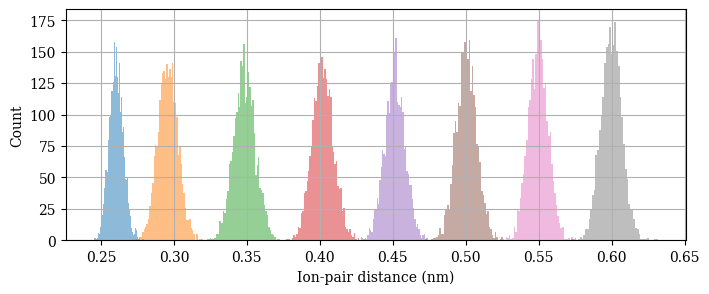

In [17]:
pullx_data = [np.transpose(np.loadtxt(f'large_k/colvar/colvar_multi.{i}.dat', comments=['@', '#'])) for i in range(8)]
dist_list = [data[1] for data in pullx_data]

plt.figure(figsize=(8, 3))
for i in range(8):
    print(f'Replica {i}: mean = {np.mean(dist_list[i]):.3f} nm, std = {np.std(dist_list[i]):.3f} nm')
    plt.hist(dist_list[i], bins=50, alpha=0.5)
plt.xlabel('Ion-pair distance (nm)')
plt.ylabel('Count')
plt.grid()

Given a large force constant used for each umbrella potential this time, each distribution barely drifted away from the desired center, but there is also no overlap between neighboring states as the spread of each distribution is narrower.

## 4-3. The relationship between the spread of the CV distribution and the force constant.

Intuitively, the spread of the CV distribution should be smaller given a large force constant specified in the harmonic potential because the energy penalty incurred by the deviation from the desired center is larger, but if you wonder if there is a mathematical relationship between the the two, please keep reading. 

For a one-dimensional simple harmonic potential with a force constant $K$, it can be dervied that its probability distribution is a normal distribution: $$P(x)=\sqrt{\frac{\beta K}{2\pi}}\exp\left (-\frac{\beta K}{2}(x-x_c)^2\right)$$ and the corresponding standard deviation is $\sigma=1/\sqrt{\beta K}$. (See [this post](https://weitsehsu.com/course/advanced_sampling/intro/#exercise-2) for how this is dervied.) Although the system we are using here is more than just a harmonic potential since there are also interatomic potentials involved in the Boltzmann distribution, the relationship above can still give a rough estimate of the distribution spread given a force constant, epsecially when the biased harmonic potential is relatively large compared to the contribution of the system potential itself. This can happen when
- A really large force constant is used.
- The immobile group and the pull group are far away from each other. 

For example, in the case where we use $K=50000$, the relationship $\sigma = 1/\sqrt{\beta K}$ yields an estimate of 0.007 nm for the standard deviation of the ion-pair distance, which is pretty close to what we got from the simulation. On the other hnad, the estimates (0.07 nm) of the standard devaitions for the case where $K=500$ are not as good because the biased potential is not large enough to shield the contribution from the interatomic potentials in the Boltzmann distribution. 

Such estimates can help us decide how large the force constant should be. For example, the spacing between windows we have in this exercise is 0.05 nm. (This can be decided by the CV range you want to sample, and the number of umbrella potentials based on the number or cores/nodes you have, as we discussed in the lecture/Exercise 2.) To have a non-zero overlap between neighboring distributions, $3\sigma$ should at least be larger than 0.025 nm, which means that the force constant should not exceed 36000 $\mathrm{kJ/mol/nm^2}$. To have a "sufficient" overlap, having $3\sigma$ around one spacing (0.05 nm) is generally a good starting point, which yields a force constant of 9000 $\mathrm{kJ/mol/nm^2}$. In this exercise, I tried to make the spread a little wider by using a slighly smaller force constant of 8000 $\mathrm{kJ/mol/nm^2}$.

Notably, for an N-dimensional harmonic potential $U(x_1, x_2, ..., x_N) = \frac{1}{2}K \left ( (x_1-x_{c, 1})^2 + (x_2 - x_{c, 2})^2 + ... + (x_N - x_{c, N})^2 \right )$, the probability distribution can be expressed below:

$$P(x_1, x_2, ..., x_N)=\left (\frac{\beta K}{2\pi}\right )^{\frac{N}{2}}\exp\left (-\frac{\beta K}{2}(x_1-x_{c, 1})^2\right)\exp\left (-\frac{\beta K}{2}(x_2-x_{c, 2})^2\right)... \exp\left (-\frac{\beta K}{2}(x_N-x_{c, N})^2\right)$$ 

from which you can estimate the force constant in difference CV directions if you are using multiple CVs in your umbrella sampling or REUS simulations. 

## References
- The paper that proposed replica exchange umbrella sampling: [Sugita, Yuji, Akio Kitao, and Yuko Okamoto. "Multidimensional replica-exchange method for free-energy calculations." The Journal of chemical physics 113.15 (2000): 6042-6051.](https://doi.org/10.1063/1.1308516)

## Takeaways

- Choosing an appropriate force constant is important for simulations where we want to fix the configurations around a certain region of CVs. 
- Using Hamiltonian replica exchange, we are able to recover a free energy surface for the NaCl system that is consistent with umbrella sampling and multiple walkers metadynamics!